# Составление SQL-запросов. Практика

### Составление SQL-запросов с помощью библиотеки SQLAlchemy на базе данных StackOverflow.

![ER-диаграмма](https://pictures.s3.yandex.net/resources/0.1_2880border_1638351696.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`

Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

# создание подключения
engine = create_engine(connection_string)

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [3]:
query = '''
        SELECT *
        FROM stackoverflow.users
        LIMIT 10;
        
        '''

sample_df = pd.read_sql_query(query, con=engine)
sample_df.head()

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700


### Задание №1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [4]:
query = '''
        SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
               SUM(views_count) AS total_views
        
        FROM stackoverflow.posts AS p
        
        WHERE EXTRACT(YEAR FROM creation_date) = 2008
        
        GROUP BY month_date
        
        HAVING SUM(views_count) IS NOT NULL
        
        ORDER BY total_views DESC
        '''
ex1_df = pd.read_sql_query(query, con=engine)
ex1_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Вывод:**

* В июле просмотров значительно меньше, чем в последующие месяцы. Это может быть бета-тест проекта, либо данные за месяц неполные.
* С августа по сентябрь количество просмотров растет, а с октября по декабрь снижается.
* Пик по просмотрам приходится на сентябрь 2008 года.

### Задание №2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [5]:
query = '''
        SELECT u.display_name,
               COUNT(p.user_id) AS cnt_answer
               
        FROM stackoverflow.posts AS p
        
        JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
        JOIN stackoverflow.users AS u ON p.user_id = u.id
        
        WHERE pt.type = 'Answer' 
          AND DATE_TRUNC('month', p.creation_date)::date >= DATE_TRUNC('month', u.creation_date)::date + INTERVAL '1 month'
          
        GROUP BY u.display_name
        
        HAVING COUNT(p.user_id) > 100
        
        ORDER BY display_name
        
        '''


In [6]:
ex2_df = pd.read_sql_query(query, con=engine)
ex2_df

,display_name,cnt_answer
0,1800 INFORMATION,226
1,Adam Bellaire,103
2,Adam Davis,216
3,Adam Rosenfield,202
4,Alnitak,140
...,...,...
159,splattne,159
160,toolkit,124
161,tvanfosson,722
162,warren,221


Какие аномалии наблюдаются в данных? О чём они говорят?

In [7]:
query = '''
        SELECT p.id,
               u.display_name,
               p.creation_date::date AS post_dt,
               u.creation_date::date AS reg_dt,
               p.creation_date::date - u.creation_date::date AS delta_days
               
        FROM stackoverflow.posts AS p
        
        JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
        JOIN stackoverflow.users AS u ON p.user_id = u.id
        
        WHERE pt.type = 'Answer'
        ORDER BY delta_days
        
        '''

In [8]:
ex2_anomaly = pd.read_sql_query(query, con=engine)
ex2_anomaly

,id,display_name,post_dt,reg_dt,delta_days
0,62374,pro,2008-09-15,2010-05-28,-620
1,80520,pro,2008-09-17,2010-05-28,-618
2,80197,pro,2008-09-17,2010-05-28,-618
3,80109,pro,2008-09-17,2010-05-28,-618
4,220127,pro,2008-10-20,2010-05-28,-585
...,...,...,...,...,...
191446,400151,Bob,2008-12-30,2008-08-01,151
191447,399766,Michael Stum,2008-12-30,2008-08-01,151
191448,401845,Michael Stum,2008-12-30,2008-08-01,151
191449,401829,Dillie-O,2008-12-30,2008-08-01,151


В данных есть посты, сделанные раньше даты регистрации пользователя - отрицательные значения в столбце delta_days.

### Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [9]:
query = '''         
        SELECT DATE_TRUNC('month', p.creation_date)::date AS month,
               COUNT(p.id)
               
        FROM stackoverflow.posts AS p
        
        JOIN stackoverflow.users AS u ON p.user_id = u.id
        
        WHERE DATE_TRUNC('month', u.creation_date) = '01.09.2008'
          AND p.user_id IN (SELECT DISTINCT user_id
                            FROM stackoverflow.posts
                            WHERE DATE_TRUNC('month', creation_date) = '01.12.2008')
        GROUP BY month
        
        ORDER BY month DESC
        
        '''

In [10]:
ex3_df = pd.read_sql_query(query, con=engine)
ex3_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

### Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [11]:
query = ''' 
        SELECT user_id,
               creation_date,
               views_count,
               SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
               
        FROM stackoverflow.posts AS p
        ORDER BY user_id
        
        '''

In [12]:
ex4_df = pd.read_sql_query(query, con=engine)
ex4_df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


### Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [13]:
query = ''' 
        WITH cte AS
        (SELECT user_id,
               COUNT(id) AS cnt_posts
        FROM stackoverflow.posts AS p
        WHERE DATE_TRUNC('month',creation_date) = '01.08.2008'
        GROUP BY user_id
        HAVING COUNT(id) > 120),
        
        cte2 AS
        (SELECT cte.user_id,
               p.creation_date::date,
               COUNT(p.id) AS cnt_daily
        FROM stackoverflow.posts AS p
        JOIN cte ON p.user_id = cte.user_id
        WHERE DATE_TRUNC('month',creation_date) = '01.08.2008'
        GROUP BY cte.user_id, p.creation_date::date)
        
        SELECT user_id,
               AVG(cnt_daily) AS avg_daily
        FROM cte2
        GROUP BY user_id
        ORDER BY avg_daily

        '''

In [14]:
ex5_df = pd.read_sql_query(query, con=engine)
ex5_df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


### Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

<details>

<summary>Подсказка</summary>
Посчитайте, сколько активных дней было у каждого пользователя. Добавьте данные во временную таблицу и используйте в основном запросе.
</details>

In [15]:
query = ''' 
        WITH cte AS
        (SELECT user_id,
                COUNT(DISTINCT creation_date::date) AS cnt_days
        FROM stackoverflow.posts AS p
        WHERE creation_date::date BETWEEN '01.12.2008' AND '07.12.2008'
        GROUP BY user_id)
        
        SELECT ROUND(AVG(cnt_days)) AS result
        FROM cte
       
        '''

In [16]:
ex6_df = pd.read_sql_query(query, con=engine)
ex6_df

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

**Вывод:** В среднем с 1 по 7 декабря пользователь взимодействовал с платформой 2 раза. Сложно сказать, много это или мало, нужно сравнивать с другими периодами.

Возьмем другие недели в 2008 году и посчитаем среднее количество активных дней у пользователей для них.

In [17]:
query = ''' 
        WITH cte AS
        (SELECT user_id,
               EXTRACT(WEEK FROM creation_date) AS week,
               COUNT(DISTINCT creation_date::date) AS cnt_days
        FROM stackoverflow.posts AS p
        WHERE EXTRACT(YEAR FROM creation_date) = 2008
        GROUP BY user_id, week)
        
        SELECT week,
               ROUND(AVG(cnt_days)) AS result
        FROM cte
        GROUP BY week
        ORDER BY week
        
        '''

In [18]:
ex6_dop = pd.read_sql_query(query, con=engine)
ex6_dop

,week,result
0,1.0,1.0
1,31.0,1.0
2,32.0,2.0
3,33.0,2.0
4,34.0,2.0
5,35.0,2.0
6,36.0,2.0
7,37.0,2.0
8,38.0,2.0
9,39.0,2.0


Видим, что 2 взаимодействия - типичное значение для 2008 года, характерное для всех недель. Также видим, что основная активность начинается с 31-й недели, но при этом есть данные за 1 неделю года. Скорее всего, это ошибка в базе.

### Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [19]:
query = ''' 
        SELECT user_id,
               creation_date,
               TO_CHAR(LAG(creation_date,2,NULL) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month')
        FROM stackoverflow.posts AS p
        ORDER BY user_id, creation_date
        
        '''

In [20]:
ex7_df = pd.read_sql_query(query, con=engine)
ex7_df

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


Подсказка
Преобразовать результат оконной функции в нужное значение вам поможет аналог условного оператора в SQL: CASE <поле> WHEN <старое значение> THEN <новое значение> END.

### Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце.

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [21]:
query = ''' 
        WITH profile AS
        (SELECT *, 
               COUNT(u.user_id) OVER (PARTITION BY u.cohort_dt) AS cohort_size
        
        FROM (SELECT DISTINCT user_id,
                              FIRST_VALUE(DATE_TRUNC('month', creation_date)) 
                              OVER (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) AS cohort_dt      
              FROM stackoverflow.posts) AS u),
        
        sessions AS
        (SELECT user_id,
               DATE_TRUNC('month', creation_date) AS post_dt
        FROM stackoverflow.posts
        GROUP BY user_id,
                 post_dt)
        
        SELECT p.cohort_dt,
               s.post_dt,
               COUNT(DISTINCT p.user_id) AS user_cnt,
               p.cohort_size,
               ROUND(COUNT(DISTINCT p.user_id)*100.0 / p.cohort_size,2) AS retention_rate
        FROM profile AS p 
        JOIN sessions AS s ON p.user_id = s.user_id
        GROUP BY 1,2,4
        ORDER BY 1,2
        ''' 


In [22]:
ex8_df = pd.read_sql_query(query, con=engine)
ex8_df.head(10)

,cohort_dt,post_dt,user_cnt,cohort_size,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

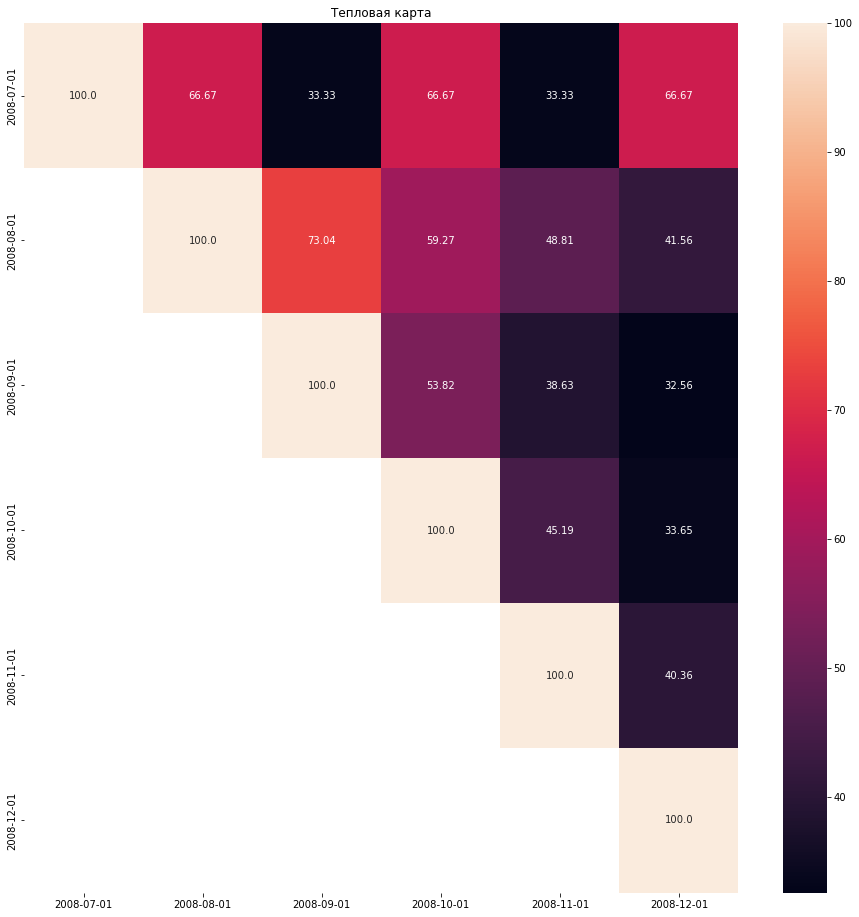

In [23]:
retention = ex8_df.pivot('cohort_dt','post_dt','retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

**Вывод:**
* В июльской когорте всего 3 пользователя - скорее всего это тестирование сервиса до выхода в общий доступ. Retention Rate для этой когорты не убывает, а скачет между значениями 66.6% и 33.3%
* У остальных когорт Retention Rate постепенно убывает, аномалий не замечено.

### Задание 9

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

Эту задачу стоит декомпозировать. Сформируйте запрос, который отобразит номер месяца и количество постов. Затем можно использовать оконную функцию, которая вернёт значение за предыдущий месяц, и посчитать процент.

In [24]:
query = '''
        WITH cte AS
        
        (SELECT TO_CHAR(DATE_TRUNC('month', creation_date),'Month') AS creation_month,
               COUNT(id) AS posts_count
        FROM stackoverflow.posts
        WHERE creation_date BETWEEN '01.09.2008' AND '31.12.2008'
        GROUP BY creation_month)
        
        SELECT *, 
               ROUND((posts_count::numeric - LAG(posts_count) 
               OVER (ORDER BY creation_month)) / LAG(posts_count) OVER (ORDER BY creation_month) * 100.0, 2) AS percentage
        FROM cte
        
        '''

In [25]:
ex9_df = pd.read_sql_query(query, con=engine)
ex9_df.head(10)

,creation_month,posts_count,percentage
0,December,44592,NaN
1,November,46975,5.34
2,October,63102,34.33
3,September,70371,11.52


Постройте круговую диаграмму с количеством постов по месяцам.

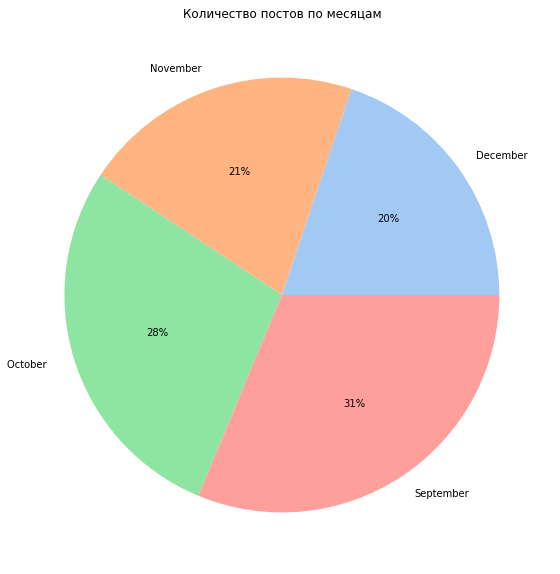

In [26]:
plt.figure(figsize=(10,10))
labels = ex9_df['creation_month']
colors = sns.color_palette('pastel')
plt.pie(ex9_df['posts_count'],autopct='%1.f%%',labels=labels, colors=colors)
plt.title('Количество постов по месяцам')
plt.show()

### Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

Декомпозируйте задачу:
1) Найдите пользователя, который опубликовал больше всего постов. 2) Найдите дату и время создания каждого поста этого пользователя и номер недели. 
3) Отобразите данные только о последних постах пользователя. Для этого можно использовать оконную функцию.

In [56]:
query = '''
        WITH max_posts AS
        (SELECT user_id,
               COUNT(id) AS cnt
        FROM stackoverflow.posts
        GROUP BY user_id
        ORDER BY cnt DESC
        LIMIT 1)
        
        SELECT DISTINCT EXTRACT(WEEK FROM creation_date) AS week_creation,
               MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date)) AS creation_dt
        FROM stackoverflow.posts AS p
        JOIN max_posts ON p.user_id = max_posts.user_id
        WHERE EXTRACT(MONTH FROM creation_date) = 10
        '''

In [57]:
ex10_df = pd.read_sql_query(query, con=engine)
ex10_df

,week_creation,creation_dt
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
